### Libraries 

In [6]:
%matplotlib inline
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Concatenate
import numpy as np
from scipy.misc import imread
import tensorflow as tf
import pickle
import keras
from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility
from random import shuffle
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

In [7]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1
input_shape = (300, 300, 3) #channel last

### Load the weight from the hdf5

In [8]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('../checkpoints/vocdevkit/weights.14-2.02.hdf5', by_name=True)

In [9]:
gt = pickle.load(open('../pkls/VOC2007.pkl', 'rb'))
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

path_prefix = '../dataset/VOCdevkit/VOC2007/JPEGImages/'
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[10]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))


In [10]:
print(inputs.shape)

(1, 300, 300, 3)


In [11]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/1 [==============================] - 1s


NameError: name 'bbox_util' is not defined

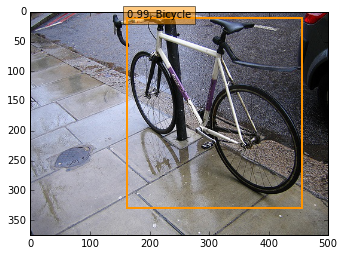

In [52]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.8]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()